In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import sys
sys.path.append('/home/mahdi_mousavi/comb-auction')

## Initialization

In [3]:
import torch
import torch.nn as nn
import logging

from comblearn.env import CombinatorialAuction

logging.basicConfig(level=20)

In [4]:
import yaml 

with open("/home/mahdi_mousavi/comb-auction/notebooks/config_lsvm.yaml") as fp:
        cfg_l = yaml.load(fp, Loader=yaml.FullLoader)

with open("/home/mahdi_mousavi/comb-auction/notebooks/config_coverage.yaml") as fp:
        cfg_c = yaml.load(fp, Loader=yaml.FullLoader) 

with open("/home/mahdi_mousavi/comb-auction/notebooks/config_submod_mini.yaml") as fp:
        cfg_s = yaml.load(fp, Loader=yaml.FullLoader) 

with open("/home/mahdi_mousavi/comb-auction/notebooks/config_mrvm.yaml") as fp:
        cfg_m = yaml.load(fp, Loader=yaml.FullLoader)

## Creating an instacne of our desired auction

In [5]:
device = "cuda"

def social_welfare(ws, allocation):
    return torch.sum(torch.tensor([w(alloc) for w, alloc in zip(ws, allocation)]).to(device))

In [6]:
auction_c = CombinatorialAuction(cfg_c['auction'])

social welfare is: 86.0, iteration is: 1000
social welfare is: 110.0, iteration is: 2000
social welfare is: 118.0, iteration is: 3000
social welfare is: 116.0, iteration is: 4000
social welfare is: 110.0, iteration is: 5000
social welfare is: 95.0, iteration is: 6000
[tensor([0., 0., 0., 1., 0., 1., 1., 1.], device='cuda:0'), tensor([1., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([0., 1., 1., 0., 0., 0., 0., 0.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 130.0


In [7]:
auction_s = CombinatorialAuction(cfg_s['auction'])

social welfare is: 1.2642836964005255e-06, iteration is: 1000
social welfare is: 1.2747310620397911e-06, iteration is: 2000
social welfare is: 1.1334110467942082e-06, iteration is: 3000
social welfare is: 6.844686595286475e-07, iteration is: 4000
social welfare is: 8.748597792873625e-07, iteration is: 5000
social welfare is: 1.1740412446670234e-06, iteration is: 6000
[tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0'), tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 1.8852898620025371e-06


In [8]:
auction_l = CombinatorialAuction(cfg_l['auction'])

In [9]:
auction_m = CombinatorialAuction(cfg_m['auction'])

## Checking how good our model learns

In [10]:
X, y = auction_s.data_handler.R['1']
items = auction_s.items
vfa = auction_s.bidders[0].vf  #if it's some sats vf then it's none, otherwise it's a function and you can use it

In [11]:
n = X.shape[0]
tr = int(80/100 * n)
X_train = X[0: tr]
y_train = y[0: tr] 
X_test = X[tr:]
y_test = y[tr:] 

In [12]:
y_test.max()

tensor(1.6316e-07, device='cuda:0', grad_fn=<MaxBackward1>)

In [27]:
y = (y - y.min())/(y.max() - y.min()) #if you want to normalize your data

In [9]:
# not that important, soon be deleted

class MLP(nn.Module):
    def __init__(self, in_feature, **kwargs) -> None:
        super().__init__()

        self.linear1 = nn.Linear(in_features=in_feature, out_features=128)
        # self.norm1 = nn.LayerNorm(256)
        self.sigmoid1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(128, 128)
        # self.norm2 = nn.LayerNorm(512)
        self.sigmoid2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, X):
        x = self.sigmoid1(self.dropout1(self.linear1(X)))
        x = self.sigmoid2(self.dropout2(self.linear2(x)))
        output = self.linear3(x)

        # X = self.sigmoid1(self.linear1(X))
        # output = self.linear3(X)

        return output

vf = MLP(len(items)).to('cuda')

In [15]:
from comblearn.data import DSFValueFunction

vf = DSFValueFunction(items, 60, [64, 64, 64], 2)

In [13]:
from comblearn.data import ExtendedDSFValueFunction

vf = ExtendedDSFValueFunction(items, 60, [64, 64, 64], 1)

In [34]:
from comblearn.data import DSFValueFunction

class Mindsf(nn.Module):
    def __init__(self, models):
        super(Mindsf, self).__init__()
        self.dsfs = nn.ParameterList()
        for m in models:
            self.dsfs.append(m)

    def forward(self, X):
        v = torch.hstack([vf(X) for vf in self.dsfs])
        # print(v)
        # return v
        return torch.min(v, dim=-1).values

    def relu(self):
        for v in self.dsfs:
            v.relu()

vf1 = DSFValueFunction(items, 90, [10, 10, 10], 20)
vf2 = DSFValueFunction(items, 90, [10, 10, 10], 20)
vf3 = DSFValueFunction(items, 90, [10, 10, 10], 20)

vf = Mindsf([vf1, vf2, vf3])

In [44]:
# in order to check the output before training

i = 30
vf(X[i]), y[i]

(tensor(3.0139e-06, device='cuda:0', grad_fn=<MinBackward0>),
 tensor([5.7891e-08], device='cuda:0', grad_fn=<SelectBackward0>))

In [32]:
# if you want to check wight before training

vf.dsf.layers[-1].linear.weight

tensor(12.1677, device='cuda:0', grad_fn=<SumBackward0>)

In [16]:
# training

from torch.nn import MSELoss
from torch.optim import Adam

optimizer = Adam(vf.parameters(), lr=0.01)
# criterion = MSELoss()
criterion = nn.L1Loss()

best_loss= 10000
best_model = None

for _ in range(18000):
    optimizer.zero_grad()
    yp = vf(X_train)
    loss = criterion(yp, y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        vf.relu()
    print(loss)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [29]:
# in order to check the output after training

i = 23
vf(X[i]), y[i]

(tensor(52., device='cuda:0', grad_fn=<MinBackward0>),
 tensor(48., device='cuda:0'))

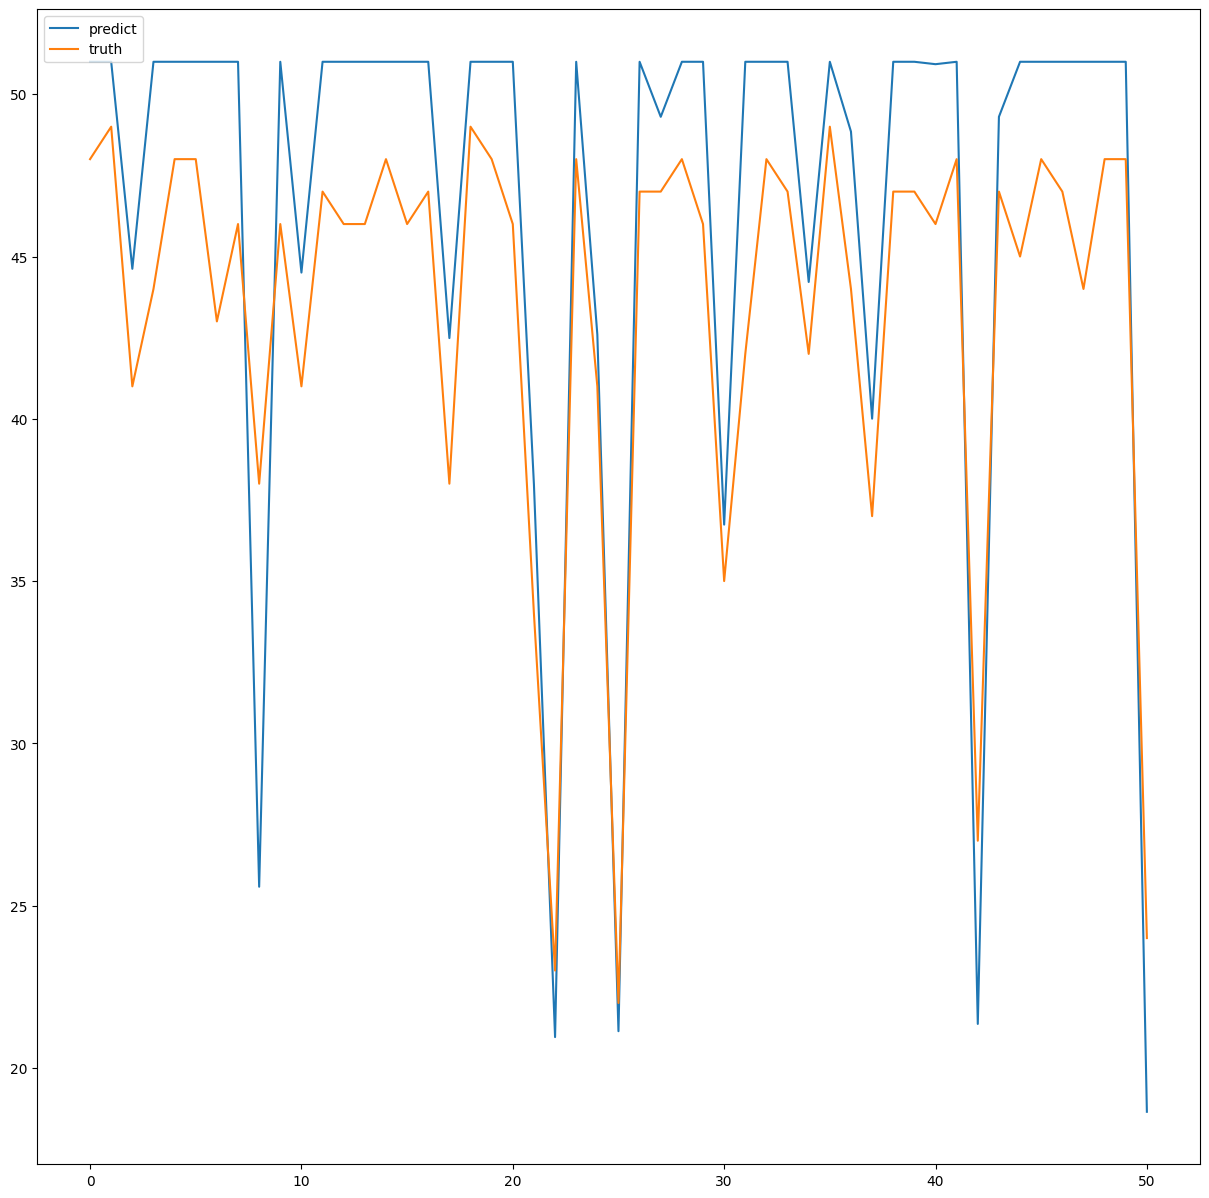

In [55]:
# if you want to plot after training

import matplotlib.pyplot as plt

x = range(X_train.shape[0])
y1 = vf(X_train).squeeze().tolist()
y2 = y_train.squeeze().tolist()

plt.figure(figsize=(15, 15))

plt.plot(x, y1, label = "predict")
plt.plot(x, y2, label = "truth")
plt.legend(loc='upper left')
plt.show()


## Finding the optimal allocations and social welfare

RandGreedy

In [ ]:
allocation_c, social_welfare_c = auction_c.run()

In [ ]:
print(f'optimal social welfare for auction with coverage value funciton is: {social_welfare_c}')
print(f'final allocation for auction with coverage value functions is: {allocation_c}')

In [ ]:
allocation_s, social_welfare_s = auction_s.run()

In [ ]:
print(f'optimal social welfare for auciton with submodular value function is: {social_welfare_s}')
print(f"final allocation for auction wiht submodular value function is: {allocation_s}")

In [ ]:
allocation_l, social_welfare_l = auction_l.run()

In [ ]:
# for lsvm or mrvm value function because we don't have their value functions here, we cant't calculate the social welfare
# Just copy the printed result and paste it to the sats file 

for b in allocation_l:
    print(f'social_welfare += lsvm.calculate_value({int(b)}, {allocation_l[b].int().tolist()})')

In [ ]:
print(f"final allocation for auction wiht LSVM value function is: {allocation_l}")

In [ ]:
allocation_m, social_welfare_m = auction_m.run()

In [ ]:
# for lsvm or mrvm value function because we don't have their value functions here, we cant't calculate the social welfare
# Just copy the printed result and paste it to the sats file 

for b in allocation_m:
    print(f'social_welfare += lsvm.calculate_value({int(b)}, {allocation_m[b].int().tolist()})')

In [ ]:
print(f"final allocation for auction wiht MRVM value function is: {allocation_m}")

GradientAscent

In [14]:
auction_c.allocation_config['scheme'] = 'GradientAscent'
auction_c.allocation_config['optimizer'] = 'comblearn.optim.GradientAscentOptimizer'  # Change this to batch if you want to perform a batch optimization
auction_c.allocation_config['learning-rate'] = 0.001
auction_c.allocation_config['batch-size'] = 100
auction_c.allocation_config['eps'] = 0.001

In [ ]:
auction_s.allocation_config['scheme'] = 'GradientAscent'
auction_s.allocation_config['optimizer'] = 'comblearn.optim.GradientAscentOptimizer'  # Change this to batch if you want to perform a batch optimization
auction_s.allocation_config['learning-rate'] = 0.001
auction_s.allocation_config['batch-size'] = 100
auction_s.allocation_config['eps'] = 0.001

In [ ]:
auction_l.allocation_config['scheme'] = 'GradientAscent'
auction_l.allocation_config['optimizer'] = 'comblearn.optim.GradientAscentOptimizer'  # Change this to batch if you want to perform a batch optimization
auction_l.allocation_config['learning-rate'] = 0.001
auction_l.allocation_config['batch-size'] = 100
auction_l.allocation_config['eps'] = 0.001

In [ ]:
auction_m.allocation_config['scheme'] = 'GradientAscent'
auction_m.allocation_config['optimizer'] = 'comblearn.optim.GradientAscentOptimizer'  # Change this to batch if you want to perform a batch optimization
auction_m.allocation_config['learning-rate'] = 0.001
auction_m.allocation_config['batch-size'] = 100
auction_m.allocation_config['eps'] = 0.001

In [ ]:
allocation_c, social_welfare_c = auction_c.run()

In [ ]:
print(f'optimal social welfare for auction with coverage value funciton is: {social_welfare_c}')
print(f'final allocation for auction with coverage value functions is: {allocation_c}')

In [ ]:
allocation_s, social_welfare_s = auction_s.run()

In [ ]:
print(f'optimal social welfare for auciton with submodular value function is: {social_welfare_s}')
print(f"final allocation for auction wiht submodular value function is: {allocation_s}")

In [ ]:
allocation_l, social_welfare_l = auction_l.run()

In [ ]:
# for lsvm or mrvm value function because we don't have their value functions here, we cant't calculate the social welfare
# Just copy the printed result and paste it to the sats file 

for b in allocation_l:
    print(f'social_welfare += lsvm.calculate_value({int(b)}, {allocation_l[b].int().tolist()})')

In [ ]:
print(f"final allocation for auction wiht LSVM value function is: {allocation_l}")

In [ ]:
allocation_m, social_welfare_m = auction_m.run()

In [ ]:
# for lsvm or mrvm value function because we don't have their value functions here, we cant't calculate the social welfare
# Just copy the printed result and paste it to the sats file 

for b in allocation_m:
    print(f'social_welfare += lsvm.calculate_value({int(b)}, {allocation_m[b].int().tolist()})')

In [ ]:
print(f"final allocation for auction wiht MRVM value function is: {allocation_m}")

## Branch & Bound
When you have DSF value function as your ground truth you can find the optimal allocation faster with this method

In [ ]:
import numpy as np

In [ ]:
class Branch_and_Bound():
    def __init__(self, dsfs, num_itmes, num_bidders):
        self.ws = dsfs
        self.m = num_itmes
        self.n = num_bidders
        self.best = -1000
        self.device = 'cuda:0'

    def run(self, variable_items_indexes=[], fixed_items={}):
        if len(fixed_items) == 0:
            variable_items_indexes = list(range(self.m))
        temp = self.gradient_ascent(fixed_items, variable_items_indexes)
        if temp > self.best:
            self.best = temp
        index = variable_items_indexes.copy()
        for item in index:
            variable_items_indexes.remove(item)
            for bidder in range(self.n):
                fixed_items[item] = bidder
                overestimate = self.gradient_ascent(fixed_items, variable_items_indexes)
                if overestimate <= self.best:
                    del(fixed_items[item])
                else:
                    self.run(variable_items_indexes, fixed_items)
            
            variable_items_indexes.append(item)
            variable_items_indexes.sort()
        return self.best



    
    def gradient_ascent(self, fixed_items, variable_items_indexes):
        temp = np.zeros((self.m, self.n))
        temp = self.projection_simplex_sort_2d(temp.T, fixed_items).T
        y = torch.from_numpy(temp).float().to('cuda:0')
        return self.optimize(variable_items_indexes, fixed_items, y)


    def optimize(self, variable_items_indexes, fixed_items, y, lr=2e-3, bs=10, num_iterations=100):
        y.requires_grad = True
        for i in range(num_iterations):
            s = torch.zeros(1).float().to(self.device)
            for b in range(self.n):
                s += self.ws[b](y[:,b])
            y.retain_grad()
            s.backward()
            with torch.no_grad():
                temp = y
                temp[variable_items_indexes, :] = y[variable_items_indexes, :] + lr*y.grad[variable_items_indexes, :]
                temp = temp.detach().cpu().numpy()
                temp = (self.projection_simplex_sort_2d(temp.T, fixed_items)).T
                y = None
                y = torch.from_numpy(temp).float().to('cuda:0')
            y.requires_grad = True
            for b in range(self.n):
                self.ws[b].zero_grad()
        max = 0
        for _ in range(10):
            allocation = self.generate_allocation(y)
            s = 0
            for b in range(self.n):
                s += self.ws[b](allocation[b]).item()
            if s > max:
                max = s
        for b in range(self.n):
            self.ws[b].zero_grad()
        return max

    def generate_allocation(self, y):
        output = torch.tensor([torch.multinomial(y[j], 1) for j in range(self.m)]).to(self.device)
        return [(output == i).float().to(self.device) for i in range(self.n)]

    def projection_simplex_sort_2d(self, v, fixed_items, z=1):
        """v array of shape (n_features, n_samples)."""
        p, n = v.shape
        u = np.sort(v, axis=0)[::-1, ...]
        pi = np.cumsum(u, axis=0) - z
        ind = (np.arange(p) + 1).reshape(-1, 1)
        mask = (u - pi / ind) > 0
        rho = p - 1 - np.argmax(mask[::-1, ...], axis=0)
        theta = pi[tuple([rho, np.arange(n)])] / (rho + 1)
        w = np.maximum(v - theta, 0)

        for k, v in fixed_items.items():
            w[:, k] = 0
            w[v, k] = 1
        return w

In [ ]:
dsfs = []
for bidder in auction.bidders:
    dsfs.append(bidder.vf)

In [ ]:
optimal = Branch_and_Bound(dsfs, 12, 3)

In [ ]:
socialwelfare = optimal.run()
socialwelfare

## junk (soon be deleted)

In [ ]:
a = torch.tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')
b = torch.tensor([0., 1., 0., 0., 0., 1., 0., 1., 0., 1.], device='cuda:0')
c = torch.tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0.], device='cuda:0')

In [ ]:
auction.bidders[0](a) + auction.bidders[1](b) + auction.bidders[2](c)

In [ ]:
surplus = 0
for i in range(len(auction.bidders)):
  surplus += auction.bidders[i](allocations[auction.bidders[i].name]).item()

In [ ]:
allocations['ali'] = torch.tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
allocations['hassan'] = torch.tensor([1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.], device='cuda:0')
allocations['mahdi'] = torch.tensor([0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')

In [ ]:
surplus = 0
for i in range(len(auction.bidders)):
  surplus += auction.bidders[i](allocations[auction.bidders[i].name]).item()

In [ ]:
surplus

In [15]:
auction.bidders[0](torch.tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0'))

tensor([50.], device='cuda:0', requires_grad=True)

In [16]:
auction.bidders[0](torch.tensor([0., 0., 0., 0., 0., 0., 1., 0.,], device='cuda:0')) + auction.bidders[0](torch.tensor([1., 1., 1., 1., 1., 1., 0., 1.], device='cuda:0'))

tensor([76.], device='cuda:0', grad_fn=<AddBackward0>)

In [17]:
auction.bidders[0](torch.tensor([0, 0, 0., 0., 0., 1., 0., 0.], device='cuda:0'))

tensor([37.], device='cuda:0', requires_grad=True)

In [ ]:
from comblearn.data import DSFValueFunction

vf = DSFValueFunction(items, )